In [ ]:
!pip install -U datasets

In [23]:
import datasets
import torch
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from datasets import load_dataset
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration

model_name = "t5-small"
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)

In [ ]:
dataset = load_dataset("conll2003")

In [5]:
labels_list = dataset['train'].features['ner_tags'].feature.names
print(labels_list)

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC', 'B-MISC', 'I-MISC']


In [24]:
def convert_to_t5_format(example):
    tokens = example["tokens"]
    tags = [labels_list[i] for i in example["ner_tags"]]

    entities = []
    entity = ""
    label = ""

    for token, tag in zip(tokens, tags):
        if tag.startswith("B-"):
            if entity:
                entities.append(f"{entity.strip()}: {label}")
            entity = token
            label = tag[2:]
        elif tag.startswith("I-") and tag[2:] == label:
            entity += " " + token
        else:
            if entity:
                entities.append(f"{entity.strip()}: {label}")
                entity = ""
                label = ""

    if entity:
        entities.append(f"{entity.strip()}: {label}")

    return {
        "input_text": "ner: " + " ".join(tokens),
        "target_text": " | ".join(entities) if entities else "None"
    }

In [8]:
train = dataset['train'].map(convert_to_t5_format)
test  = dataset['test'].map(convert_to_t5_format)
val   = dataset['validation'].map(convert_to_t5_format)

Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [25]:
def tokenize_batch(batch):
    input_enc = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=256)
    target_enc = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=64)

    batch["input_ids"] = input_enc.input_ids
    batch["attention_mask"] = input_enc.attention_mask
    batch["labels"] = target_enc.input_ids
    return batch

tokenized_train = train.map(tokenize_batch, batched=True)
tokenized_val = val.map(tokenize_batch, batched=True)
tokenized_train = tokenized_train.remove_columns(['tokens', 'ner_tags', 'input_text', 'target_text', 'id'])
tokenized_val = tokenized_val.remove_columns(['tokens', 'ner_tags', 'input_text', 'target_text', 'id'])


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [75]:
train[10]

{'id': '10',
 'tokens': ['Spanish',
  'Farm',
  'Minister',
  'Loyola',
  'de',
  'Palacio',
  'had',
  'earlier',
  'accused',
  'Fischler',
  'at',
  'an',
  'EU',
  'farm',
  'ministers',
  "'",
  'meeting',
  'of',
  'causing',
  'unjustified',
  'alarm',
  'through',
  '"',
  'dangerous',
  'generalisation',
  '.',
  '"'],
 'pos_tags': [22,
  22,
  22,
  22,
  22,
  22,
  38,
  31,
  40,
  22,
  15,
  12,
  16,
  21,
  24,
  27,
  21,
  15,
  39,
  16,
  21,
  15,
  0,
  16,
  21,
  7,
  0],
 'chunk_tags': [11,
  12,
  12,
  12,
  12,
  12,
  21,
  22,
  22,
  11,
  13,
  11,
  12,
  12,
  12,
  11,
  12,
  13,
  21,
  1,
  11,
  13,
  0,
  11,
  12,
  0,
  0],
 'ner_tags': [7,
  0,
  0,
  1,
  2,
  2,
  0,
  0,
  0,
  1,
  0,
  0,
  3,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'input_text': 'ner: Spanish Farm Minister Loyola de Palacio had earlier accused Fischler at an EU farm ministers \' meeting of causing unjustified alarm through " dangerous gen

In [26]:
model.to(device)

T5ForConditionalGeneration(
  (shared): Embedding(32128, 512)
  (encoder): T5Stack(
    (embed_tokens): Embedding(32128, 512)
    (block): ModuleList(
      (0): T5Block(
        (layer): ModuleList(
          (0): T5LayerSelfAttention(
            (SelfAttention): T5Attention(
              (q): Linear(in_features=512, out_features=512, bias=False)
              (k): Linear(in_features=512, out_features=512, bias=False)
              (v): Linear(in_features=512, out_features=512, bias=False)
              (o): Linear(in_features=512, out_features=512, bias=False)
              (relative_attention_bias): Embedding(32, 8)
            )
            (layer_norm): T5LayerNorm()
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (1): T5LayerFF(
            (DenseReluDense): T5DenseActDense(
              (wi): Linear(in_features=512, out_features=2048, bias=False)
              (wo): Linear(in_features=2048, out_features=512, bias=False)
              (dropout): Drop

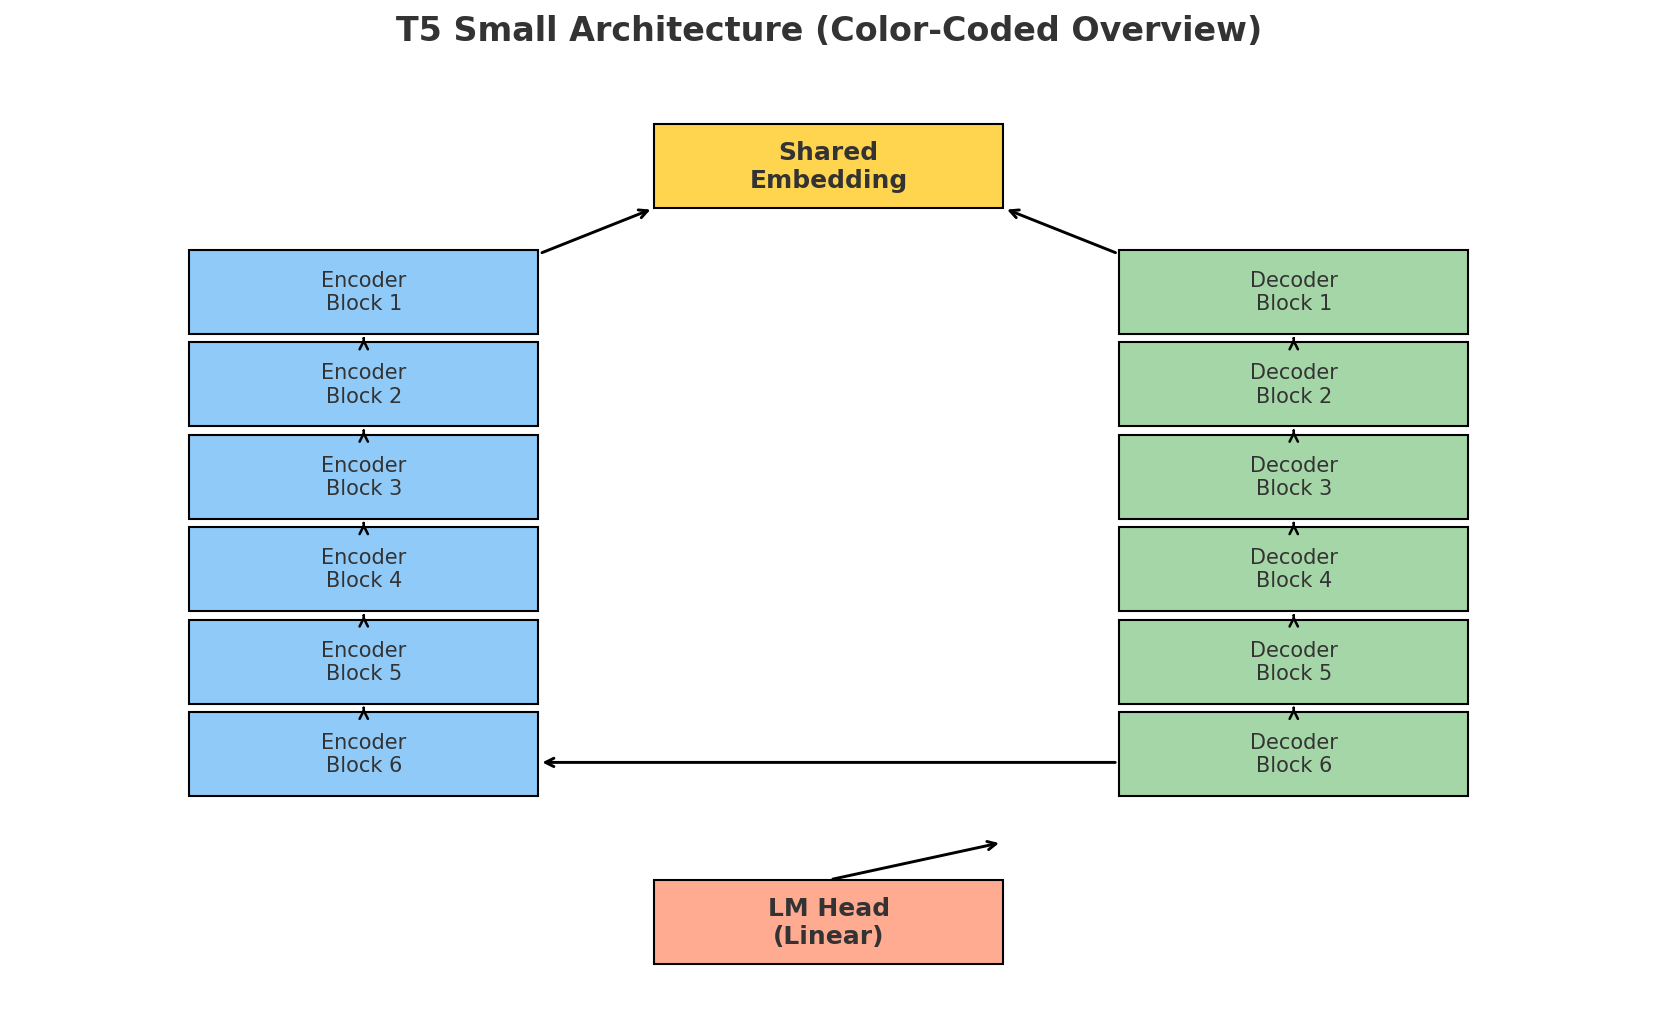

In [11]:
# fine tune encoder 1 and endoer 2

In [27]:
#Freezing all other blocks expect 1 and 2
for name,param in model.named_parameters():
  if "encoder.block.1" in name or "encoder.block.2" in name :
    param.requires_grad = True
  else:
    param.requires_grad = False

In [28]:
for name, param in model.named_parameters():
    if "encoder.block.1"  in name or "encoder.block.2"  in name:
        print(f"{name}: requires_grad={param.requires_grad} | mean={param.data.mean():.4f}")

encoder.block.1.layer.0.SelfAttention.q.weight: requires_grad=True | mean=-0.0000
encoder.block.1.layer.0.SelfAttention.k.weight: requires_grad=True | mean=-0.0008
encoder.block.1.layer.0.SelfAttention.v.weight: requires_grad=True | mean=-0.0000
encoder.block.1.layer.0.SelfAttention.o.weight: requires_grad=True | mean=0.0014
encoder.block.1.layer.0.layer_norm.weight: requires_grad=True | mean=0.1021
encoder.block.1.layer.1.DenseReluDense.wi.weight: requires_grad=True | mean=0.0008
encoder.block.1.layer.1.DenseReluDense.wo.weight: requires_grad=True | mean=-0.0000
encoder.block.1.layer.1.layer_norm.weight: requires_grad=True | mean=0.4058
encoder.block.2.layer.0.SelfAttention.q.weight: requires_grad=True | mean=0.0001
encoder.block.2.layer.0.SelfAttention.k.weight: requires_grad=True | mean=0.0002
encoder.block.2.layer.0.SelfAttention.v.weight: requires_grad=True | mean=-0.0007
encoder.block.2.layer.0.SelfAttention.o.weight: requires_grad=True | mean=0.0030
encoder.block.2.layer.0.layer

In [29]:
total_parameters = 0

for name, param in model.named_parameters():
  if "encoder.block.1" in name or "encoder.block.2" in name :
    total_parameters += param.nelement()
print('totoal number of parametes to tune' , round(total_parameters/1000000,1),'M')

totoal number of parametes to tune 6.3 M


In [30]:
device= torch.device('cuda')
class LoraParameterizarion(nn.Module):
  def __init__(self,inf,outf):
    super().__init__()
    self.rank = 4
    self.alpha = 4
    self.A_param = nn.Parameter(torch.zeros((self.rank,outf))).to(device)
    self.B_param = nn.Parameter(torch.zeros((inf, self.rank))).to(device)
    nn.init.normal_(self.A_param, mean=0, std=1)
    self.enable  = True

  def forward(self,weight):
    if self.enable:
        lora_weight = (self.alpha/self.rank) * (self.B_param @ self.A_param).view(weight.shape)

        return weight + lora_weight
    else:
      return weight

In [31]:
from torch.nn.utils import parametrize

In [32]:
def Lora_parametrization_reigster(layer):
  inf,outf = layer.weight.shape
  return LoraParameterizarion(inf,outf)

In [33]:
model.encoder.block[1].layer

ModuleList(
  (0): T5LayerSelfAttention(
    (SelfAttention): T5Attention(
      (q): Linear(in_features=512, out_features=512, bias=False)
      (k): Linear(in_features=512, out_features=512, bias=False)
      (v): Linear(in_features=512, out_features=512, bias=False)
      (o): Linear(in_features=512, out_features=512, bias=False)
    )
    (layer_norm): T5LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (1): T5LayerFF(
    (DenseReluDense): T5DenseActDense(
      (wi): Linear(in_features=512, out_features=2048, bias=False)
      (wo): Linear(in_features=2048, out_features=512, bias=False)
      (dropout): Dropout(p=0.1, inplace=False)
      (act): ReLU()
    )
    (layer_norm): T5LayerNorm()
    (dropout): Dropout(p=0.1, inplace=False)
  )
)

In [34]:
model.encoder.block[1].layer[0].SelfAttention

T5Attention(
  (q): Linear(in_features=512, out_features=512, bias=False)
  (k): Linear(in_features=512, out_features=512, bias=False)
  (v): Linear(in_features=512, out_features=512, bias=False)
  (o): Linear(in_features=512, out_features=512, bias=False)
)

In [35]:
encoder1 = [
    model.encoder.block[1].layer[0].SelfAttention.q,
    model.encoder.block[1].layer[0].SelfAttention.k,
    model.encoder.block[1].layer[0].SelfAttention.v,
    model.encoder.block[1].layer[0].SelfAttention.o,
    model.encoder.block[1].layer[1].DenseReluDense.wi,
    model.encoder.block[1].layer[1].DenseReluDense.wo
]

encoder2 = [
    model.encoder.block[2].layer[0].SelfAttention.q,
    model.encoder.block[2].layer[0].SelfAttention.k,
    model.encoder.block[2].layer[0].SelfAttention.v,
    model.encoder.block[2].layer[0].SelfAttention.o,
    model.encoder.block[2].layer[1].DenseReluDense.wi,
    model.encoder.block[2].layer[1].DenseReluDense.wo
]

Layers =[encoder1,encoder2]

In [36]:
# model.encoder.block[1].layer[0].SelfAttention.q.requires_grad = True

In [37]:
for i in range(2):
  for idx,layer in enumerate(Layers[i]):
    print(f'paramererizing encoder {i} inthat layer {idx}')
    parametrize.register_parametrization(layer,'weight',Lora_parametrization_reigster(layer))

paramererizing encoder 0 inthat layer 0
paramererizing encoder 0 inthat layer 1
paramererizing encoder 0 inthat layer 2
paramererizing encoder 0 inthat layer 3
paramererizing encoder 0 inthat layer 4
paramererizing encoder 0 inthat layer 5
paramererizing encoder 1 inthat layer 0
paramererizing encoder 1 inthat layer 1
paramererizing encoder 1 inthat layer 2
paramererizing encoder 1 inthat layer 3
paramererizing encoder 1 inthat layer 4
paramererizing encoder 1 inthat layer 5


In [59]:
from tqdm import tqdm
optimizer = torch.optim.AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-4)

def train_model(model, dataloader, epochs=5):
    model.train()
    model.to(device)
    for epoch in range(epochs):
        total_loss = 0
        for batch in tqdm(dataloader, desc="Training"):
            src = batch["input_ids"]
            att = batch["attention_mask"]
            tgt = batch["labels"]

            logits = model(input_ids=src.to(device),
                attention_mask=att.to(device),
                labels=tgt.to(device))
            loss = logits.loss
            # print(loss)
            # loss = f.cross_entropy(logits.view(-1, logits.size(-1)), tgt[:, 1:].reshape(-1), ignore_index=0)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            total_loss += loss.item()

        print(f"Epoch {epoch+1} | Loss: {total_loss:.4f}")


In [60]:
from torch.utils.data import DataLoader

# Set format to PyTorch tensors
tokenized_train.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

In [61]:
train_loader = DataLoader(tokenized_train, batch_size=8, shuffle=True)
val_loader   = DataLoader(tokenized_val, batch_size=8)


In [65]:
for batch in train_loader:
    input_ids = batch["input_ids"]
    attention_mask = batch["attention_mask"]
    labels = batch["labels"]
    break


In [63]:
train_model(model, train_loader)

Training: 100%|██████████| 1756/1756 [03:16<00:00,  8.92it/s]


Epoch 1 | Loss: 328.6778


Training: 100%|██████████| 1756/1756 [03:16<00:00,  8.95it/s]


Epoch 2 | Loss: 179.7034


Training: 100%|██████████| 1756/1756 [03:16<00:00,  8.96it/s]


Epoch 3 | Loss: 120.0183


Training: 100%|██████████| 1756/1756 [03:16<00:00,  8.95it/s]


Epoch 4 | Loss: 95.7891


Training: 100%|██████████| 1756/1756 [03:15<00:00,  8.98it/s]

Epoch 5 | Loss: 78.9690


In [76]:
from transformers import T5Tokenizer

tokenizer = T5Tokenizer.from_pretrained("t5-small")

def tokenize_batch(batch):
    input_enc = tokenizer(batch["input_text"], padding="max_length", truncation=True, max_length=256)
    target_enc = tokenizer(batch["target_text"], padding="max_length", truncation=True, max_length=64)

    batch["input_ids"] = input_enc.input_ids
    batch["attention_mask"] = input_enc.attention_mask
    batch["labels"] = target_enc.input_ids
    return batch

tokenized_val = val.map(tokenize_batch, batched=True)
tokenized_val.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])


Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

In [77]:
from torch.utils.data import DataLoader
val_loader = DataLoader(tokenized_val, batch_size=4)

model.eval()

from tqdm import tqdm
decoded_preds = []
decoded_labels = []
decoded_inputs = []

for batch in tqdm(val_loader):
    input_ids = batch["input_ids"].to(device)
    labels = batch["labels"].to(device)

    with torch.no_grad():
        outputs = model.generate(input_ids, max_length=64)

    # Decode using tokenizer
    decoded_preds += tokenizer.batch_decode(outputs, skip_special_tokens=True)
    decoded_labels += tokenizer.batch_decode(labels, skip_special_tokens=True)
    decoded_inputs += tokenizer.batch_decode(input_ids, skip_special_tokens=True)


100%|██████████| 813/813 [04:51<00:00,  2.79it/s]


In [79]:
for i in range(50):
    print(f"Input     : {decoded_inputs[i]}")
    print(f"Target    : {decoded_labels[i]}")
    print(f"Prediction: {decoded_preds[i]}")
    print("-" * 50)

Input     : ner: CRICKET - LEICESTERSHIRE TAKE OVER AT TOP AFTER INNINGS VICTORY.
Target    : LEICESTERSHIRE: ORG
Prediction: LEICESTERSHIRE: ORG | TOP: LOC
--------------------------------------------------
Input     : ner: LONDON 1996-08-30
Target    : LONDON: LOC
Prediction: LONDON: LOC
--------------------------------------------------
Input     : ner: West Indian all-rounder Phil Simmons took four for 38 on Friday as Leicestershire beat Somerset by an innings and 39 runs in two days to take over at the head of the county championship.
Target    : West Indian: MISC | Phil Simmons: PER | Leicestershire: ORG | Somerset: ORG
Prediction: West Indian: MISC | Phil Simmons: PER | Leicestershire: ORG | Somerset: ORG
--------------------------------------------------
Input     : ner: Their stay on top, though, may be short-lived as title rivals Essex, Derbyshire and Surrey all closed in on victory while Kent made up for lost time in their rain-affected match against Nottinghamshire.
Target 